*kaggle: whykitsune*

###Импорт библиотек и загрузка датасета

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
train_path = Path('./train/')
test_path = Path('./testset')

In [ ]:
train_val_files = sorted(list(train_path.rglob('*.jpg')))
test_files = sorted(list(test_path.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

Разделим тренировочную выборку на train val

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
data_modes = ["train", "test", "val"]
rescale_size = 224

Ниже мы используем враппер над датасетом для удобной работы\
Воспользуемся трансформером для аугментации данных

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in data_modes:
            print(f"{self.mode} is not correct; correct modes: {data_modes}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(0.3),
            transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((rescale_size, rescale_size))
        return np.array(image)

Напишем функцию для вывода картинки

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_dataset = SimpsonsDataset(train_files, "train")
val_dataset = SimpsonsDataset(val_files, "val")
test_dataset = SimpsonsDataset(test_files, "test")

Посмотрим на героев внутри датасета

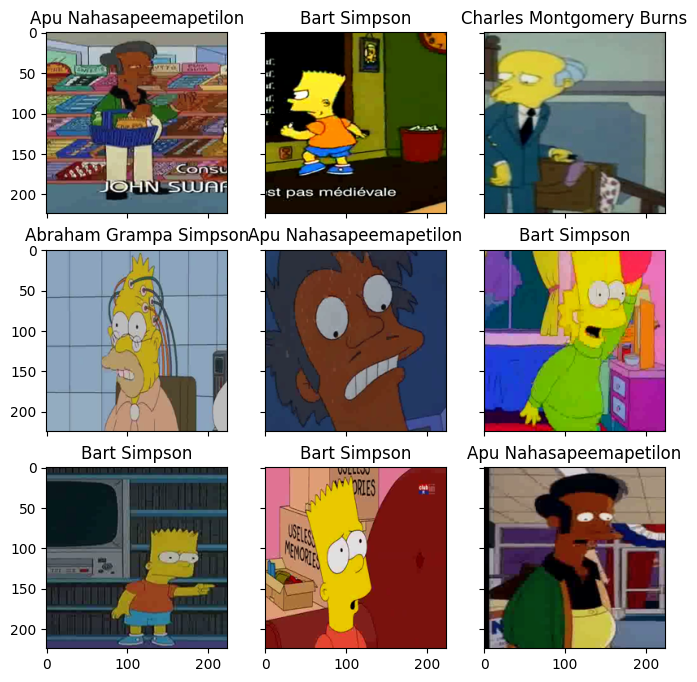

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

###Функции для обучения

Напишем функции для обучения модели и ее предсказаний

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, optimizer):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

###Попробуем ResNet18

In [ ]:
# model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# layer = 0

# for child in model.children():
#     layer += 1
#     if layer <= 7:
#         for param in child.parameters():
#             param.requires_grad = False

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
# model.fc = nn.Linear(512, n_classes)
# model.fc

Linear(in_features=512, out_features=42, bias=True)

In [ ]:
# from itertools import chain

# optimizer = torch.optim.Adam(
#     chain(
#         list(model.layer4.parameters()),
#         model.fc.parameters()
#     ),
#     lr=1e-4,
# )

In [ ]:
# model = model.to(device)

In [ ]:
# history = train(train_dataset, val_dataset, model, epochs=10, batch_size=64, optimizer=optimizer)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.1189830014926474


epoch:  10%|█         | 1/10 [02:41<24:13, 161.46s/it]


Epoch 001 train_loss: 1.1190     val_loss 0.4881 train_acc 0.7570 val_acc 0.8963
loss 0.33173334455025394


epoch:  20%|██        | 2/10 [05:22<21:27, 161.00s/it]


Epoch 002 train_loss: 0.3317     val_loss 0.3495 train_acc 0.9138 val_acc 0.9091
loss 0.1650125479451537


epoch:  30%|███       | 3/10 [08:04<18:49, 161.41s/it]


Epoch 003 train_loss: 0.1650     val_loss 0.3101 train_acc 0.9552 val_acc 0.9255
loss 0.09665880336846389


epoch:  40%|████      | 4/10 [10:59<16:41, 166.86s/it]


Epoch 004 train_loss: 0.0967     val_loss 0.2800 train_acc 0.9748 val_acc 0.9303
loss 0.05872880623358679


epoch:  50%|█████     | 5/10 [14:32<15:17, 183.45s/it]


Epoch 005 train_loss: 0.0587     val_loss 0.3214 train_acc 0.9844 val_acc 0.9291
loss 0.043878053386231596


epoch:  60%|██████    | 6/10 [18:04<12:53, 193.29s/it]


Epoch 006 train_loss: 0.0439     val_loss 0.2398 train_acc 0.9890 val_acc 0.9457
loss 0.03370973159058913


epoch:  70%|███████   | 7/10 [21:34<09:56, 198.90s/it]


Epoch 007 train_loss: 0.0337     val_loss 0.2639 train_acc 0.9918 val_acc 0.9410
loss 0.03415233579184427


epoch:  80%|████████  | 8/10 [25:24<06:57, 208.53s/it]


Epoch 008 train_loss: 0.0342     val_loss 0.2238 train_acc 0.9906 val_acc 0.9488
loss 0.019601830439652156


epoch:  90%|█████████ | 9/10 [29:04<03:32, 212.39s/it]


Epoch 009 train_loss: 0.0196     val_loss 0.2714 train_acc 0.9952 val_acc 0.9463
loss 0.020575738491987496


epoch: 100%|██████████| 10/10 [32:48<00:00, 196.90s/it]


Epoch 010 train_loss: 0.0206     val_loss 0.2731 train_acc 0.9944 val_acc 0.9433


In [ ]:
# loss, acc, val_loss, val_acc = zip(*history)

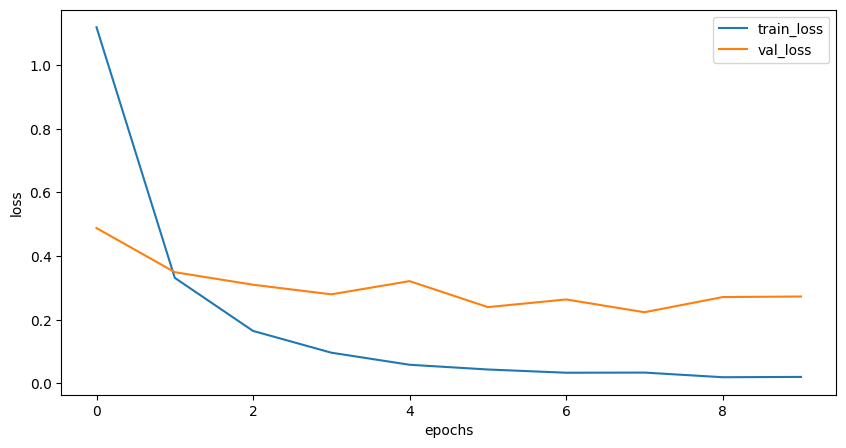

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.plot(loss, label="train_loss")
# plt.plot(val_loss, label="val_loss")
# plt.legend(loc='best')
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=device):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
# probs_ims = predict(model, imgs)

# actual_labels = [val_dataset[id][1] for id in idxs]
# y_pred = np.argmax(probs_ims,-1)

In [ ]:
# from sklearn.metrics import f1_score
# f1 = f1_score(actual_labels, y_pred, average='micro')

# print("F1-оценка:", f1)

F1-оценка: 0.9


###ResNet50

Теперь попробуем resnet50, где заморозим первые 7 слоев

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.fc = nn.Linear(2048, n_classes)
model.fc

Linear(in_features=2048, out_features=42, bias=True)

In [ ]:
layer = 0

for child in model.children():
    layer += 1
    if layer < 7:
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
from itertools import chain

optimizer = torch.optim.Adam(
    chain(
        list(model.layer3.parameters()),
        list(model.layer4.parameters()),
        model.fc.parameters()
    ),
    lr=1e-4,
)

In [ ]:
model = model.to(device)

In [ ]:
history = train(train_dataset, val_dataset, model, epochs=10, batch_size=64, optimizer=optimizer)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5562624822407667


epoch:  10%|█         | 1/10 [04:06<36:58, 246.54s/it]


Epoch 001 train_loss: 0.5563     val_loss 0.2201 train_acc 0.8836 val_acc 0.9492
loss 0.2654214450618827


epoch:  20%|██        | 2/10 [08:05<32:15, 241.92s/it]


Epoch 002 train_loss: 0.2654     val_loss 0.2321 train_acc 0.9329 val_acc 0.9392
loss 0.1286339304889909


epoch:  30%|███       | 3/10 [12:06<28:10, 241.49s/it]


Epoch 003 train_loss: 0.1286     val_loss 0.1753 train_acc 0.9667 val_acc 0.9601
loss 0.08502014670303897


epoch:  40%|████      | 4/10 [16:10<24:14, 242.40s/it]


Epoch 004 train_loss: 0.0850     val_loss 0.2050 train_acc 0.9775 val_acc 0.9566
loss 0.0833171549587692


epoch:  50%|█████     | 5/10 [20:09<20:06, 241.38s/it]


Epoch 005 train_loss: 0.0833     val_loss 0.2517 train_acc 0.9785 val_acc 0.9433
loss 0.06198056127741163


epoch:  60%|██████    | 6/10 [24:10<16:05, 241.27s/it]


Epoch 006 train_loss: 0.0620     val_loss 0.1933 train_acc 0.9823 val_acc 0.9597
loss 0.07973694267013975


epoch:  70%|███████   | 7/10 [28:11<12:03, 241.01s/it]


Epoch 007 train_loss: 0.0797     val_loss 0.2045 train_acc 0.9803 val_acc 0.9503
loss 0.04573688311326146


epoch:  80%|████████  | 8/10 [32:11<08:01, 240.76s/it]


Epoch 008 train_loss: 0.0457     val_loss 0.1877 train_acc 0.9878 val_acc 0.9595
loss 0.04340394879286567


epoch:  90%|█████████ | 9/10 [36:10<04:00, 240.36s/it]


Epoch 009 train_loss: 0.0434     val_loss 0.1625 train_acc 0.9877 val_acc 0.9647
loss 0.04158608384234759


epoch: 100%|██████████| 10/10 [40:11<00:00, 241.19s/it]


Epoch 010 train_loss: 0.0416     val_loss 0.1291 train_acc 0.9892 val_acc 0.9715


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

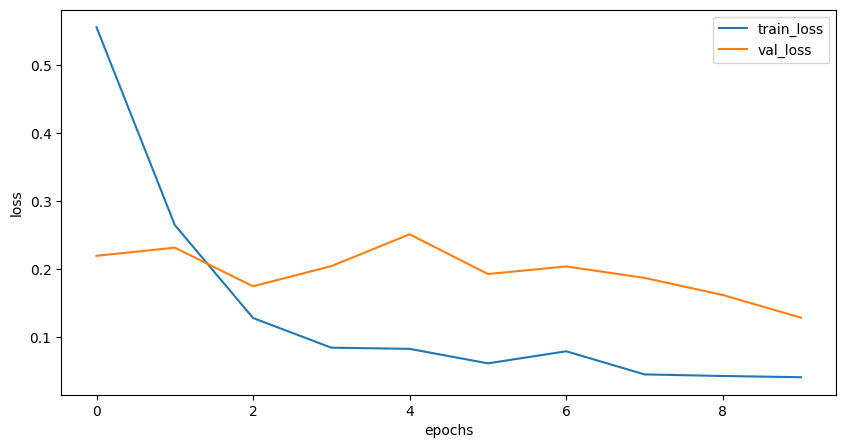

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)

actual_labels = [val_dataset[id][1] for id in idxs]
y_pred = np.argmax(probs_ims,-1)

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


Лучший результат получили во втором случае\
Его будем использовать для test

###Предсказания для test датасета

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model, test_dataloader)
preds = np.argmax(probs,-1)
predictions = train_dataset.label_encoder.inverse_transform(preds)

In [ ]:
import pandas as pd
test_filenames = [path.name for path in test_dataset.files]

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
pd.DataFrame({'Id': test_filenames, 'Expected': predictions}).to_csv('preds.csv', index=False)

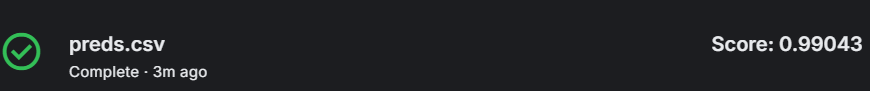